# IMDb Movie Review Sentiment Analysis Using RNN

In this notebook, we'll implement a recurrent neural network that performs sentiment analysis. Using an RNN, rather than a feedfoward network is more accurate since we can include information about the sequence of words. Here we'll use a dataset of movie reviews, accompanied by labels.

The architecture for this RNN network look like :
![alt text](https://cdn-images-1.medium.com/max/1200/1*UkI9za9zTR-HL8uM15Wmzw.png)

### Data Set( Data Used to train the model is from Kaggle)
The labeled data set consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Train Data

In [2]:
train_data=pd.read_csv('labeledTrainData.tsv', sep='\t')

In [3]:
train_data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
train_data.shape

(25000, 3)

As we can see in the review section that the data is very noisy. So first let's clear that up.

### Test Data

In [5]:
test_data=pd.read_csv('testData.tsv', sep='\t')

In [6]:
test_data.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


## Data preprocessing¶
The first step when building a neural network model is getting your data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer. We'll also want to clean it up a bit.

You can see an example of the reviews data above. We'll want to get rid of those periods. Also, you might notice that the reviews are delimited with newlines \n. To deal with those, I'm going to split the text into each review using \n as the delimiter. Then I can combined all the reviews back together into one big string.

First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

In [7]:
# Import packages required during data processing.
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
stemmer = PorterStemmer()

from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nehak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def clean_text(text):
  clean_review=[]
  for i in text:
    
 
    text = re.sub(r'[^\w\s]','',i, re.UNICODE)
    text = text.lower()

    clean_review.append(text)
  return clean_review

In [9]:
#train 
d1=train_data['review']
data=clean_text(d1)

In [10]:
# test
d2=test_data['review']
data_test=clean_text(d2)

In [11]:
# train
train_data['review']=pd.Series(data)
train_data.head()
# Here we can see more cleaner review.

,id,sentiment,review
0,5814_8,1,with all this stuff going down at the moment w...
1,2381_9,1,the classic war of the worlds by timothy hines...
2,7759_3,0,the film starts with a manager nicholas bell g...
3,3630_4,0,it must be assumed that those who praised this...
4,9495_8,1,superbly trashy and wondrously unpretentious 8...


In [12]:
# test
test_data['review']=pd.Series(data_test)
test_data.head()

,id,review
0,12311_10,naturally in a film whos main themes are of mo...
1,8348_2,this movie is a disaster within a disaster fil...
2,5828_4,all in all this is a movie for kids we saw it ...
3,7186_2,afraid of the dark left me with the impression...
4,12128_7,a very accurate depiction of small time mob li...


In [13]:
test_data.shape

(25000, 2)

## Tokenization
Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

#### Train

In [14]:
# first lets remove all the words of len less then 3.
train_data['review'] = train_data['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [15]:
tokenized_review = train_data['review'].apply(lambda x: x.split())
tokenized_review.head()

0    [with, this, stuff, going, down, moment, with,...
1    [classic, worlds, timothy, hines, very, entert...
2    [film, starts, with, manager, nicholas, bell, ...
3    [must, assumed, that, those, praised, this, fi...
4    [superbly, trashy, wondrously, unpretentious, ...
Name: review, dtype: object

**Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing. **

#### Test

In [16]:
# first lets remove all the words of len less then 3.
test_data['review'] = test_data['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [17]:
tokenized_review_test = test_data['review'].apply(lambda x: x.split())
tokenized_review_test.head()

0    [naturally, film, whos, main, themes, mortalit...
1    [this, movie, disaster, within, disaster, film...
2    [this, movie, kids, tonight, child, loved, poi...
3    [afraid, dark, left, with, impression, that, s...
4    [very, accurate, depiction, small, time, life,...
Name: review, dtype: object

### Stemming
Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.

In [18]:
#Train
from nltk.stem.porter import *
stemmer = PorterStemmer()

stem_review = tokenized_review.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
stem_review.head()

0    [with, thi, stuff, go, down, moment, with, sta...
1    [classic, world, timothi, hine, veri, entertai...
2    [film, start, with, manag, nichola, bell, give...
3    [must, assum, that, those, prais, thi, film, g...
4    [superbl, trashi, wondrous, unpretenti, exploi...
Name: review, dtype: object

In [19]:
#Test
stem_review_test = tokenized_review_test.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
stem_review_test.head()

0    [natur, film, who, main, theme, mortal, nostal...
1    [thi, movi, disast, within, disast, film, full...
2    [thi, movi, kid, tonight, child, love, point, ...
3    [afraid, dark, left, with, impress, that, seve...
4    [veri, accur, depict, small, time, life, film,...
Name: review, dtype: object

### Remove the stop words

In [20]:
def remove_stop(review):
  final_review=[]
  for i in review:
    text = [word for word in i if not word in stop_words]
    text = " ".join(text)  
    final_review.append(text)
  return final_review   

In [21]:
#train
final_review=remove_stop(stem_review)

In [22]:
#test
final_review_test=remove_stop(stem_review_test)

In [23]:
# Now lets put it back in to our data frame and compare to the earlier one

train_data['stem_review']=final_review

In [24]:
test_data['stem_review_test']=final_review_test

In [25]:
train_data.head()

,id,sentiment,review,stem_review
0,5814_8,1,with this stuff going down moment with started...,thi stuff go moment start listen music watch d...
1,2381_9,1,classic worlds timothy hines very entertaining...,classic world timothi hine veri entertain film...
2,7759_3,0,film starts with manager nicholas bell giving ...,film start manag nichola bell give welcom inve...
3,3630_4,0,must assumed that those praised this film grea...,must assum prais thi film greatest film opera ...
4,9495_8,1,superbly trashy wondrously unpretentious explo...,superbl trashi wondrous unpretenti exploit hoo...


In [26]:
test_data.head()

,id,review,stem_review_test
0,12311_10,naturally film whos main themes mortality nost...,natur film main theme mortal nostalgia loss in...
1,8348_2,this movie disaster within disaster film full ...,thi movi disast within disast film full great ...
2,5828_4,this movie kids tonight child loved point kids...,thi movi kid tonight child love point kid exci...
3,7186_2,afraid dark left with impression that several ...,afraid dark left impress sever differ screenpl...
4,12128_7,very accurate depiction small time life filmed...,veri accur depict small time life film jersey ...


As here we can see stamming create a negative impact on the words, even some words lose out its meaning. Let's try out without stemming.

### Text without stemming.

In [27]:
def remove_stop(review):
  unstammed=[]
  for i in review:
    text = [word for word in i if not word in stop_words]
    text = " ".join(text)  
    unstammed.append(text)
  return unstammed

In [28]:
#Train
unstammed=remove_stop(tokenized_review)

train_data['final_review']=pd.Series(unstammed)

In [29]:
#Test

unstammed_test=remove_stop(tokenized_review_test)

test_data['final_review_test']=pd.Series(unstammed_test)

## Let's check out the final data

In [30]:
train_data.head()

,id,sentiment,review,stem_review,final_review
0,5814_8,1,with this stuff going down moment with started...,thi stuff go moment start listen music watch d...,stuff going moment started listening music wat...
1,2381_9,1,classic worlds timothy hines very entertaining...,classic world timothi hine veri entertain film...,classic worlds timothy hines entertaining film...
2,7759_3,0,film starts with manager nicholas bell giving ...,film start manag nichola bell give welcom inve...,film starts manager nicholas bell giving welco...
3,3630_4,0,must assumed that those praised this film grea...,must assum prais thi film greatest film opera ...,must assumed praised film greatest filmed oper...
4,9495_8,1,superbly trashy wondrously unpretentious explo...,superbl trashi wondrous unpretenti exploit hoo...,superbly trashy wondrously unpretentious explo...


In [31]:
test_data.head()

,id,review,stem_review_test,final_review_test
0,12311_10,naturally film whos main themes mortality nost...,natur film main theme mortal nostalgia loss in...,naturally film whos main themes mortality nost...
1,8348_2,this movie disaster within disaster film full ...,thi movi disast within disast film full great ...,movie disaster within disaster film full great...
2,5828_4,this movie kids tonight child loved point kids...,thi movi kid tonight child love point kid exci...,movie kids tonight child loved point kids exci...
3,7186_2,afraid dark left with impression that several ...,afraid dark left impress sever differ screenpl...,afraid dark left impression several different ...
4,12128_7,very accurate depiction small time life filmed...,veri accur depict small time life film jersey ...,accurate depiction small time life filmed jers...


Out of all three we can see the final review is the most suitable one.

## Story Generation and Visualization from Review
Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:-

What are the most common words in the entire dataset?

What are the most common words in the dataset for negative and positive review, respectively?



### Understanding the common words used in the review: WordCloud

- For train data

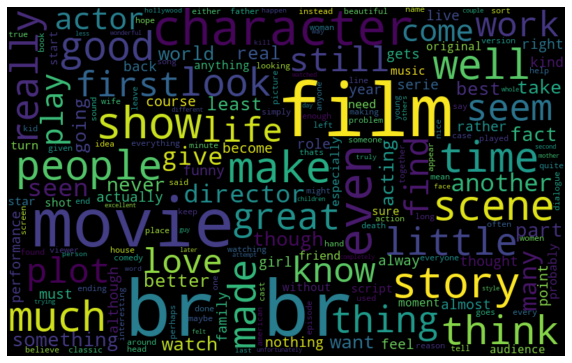

In [32]:
all_words = ' '.join([text for text in train_data['final_review']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Words in Negative sentiment review i.e Sentiment Label=0

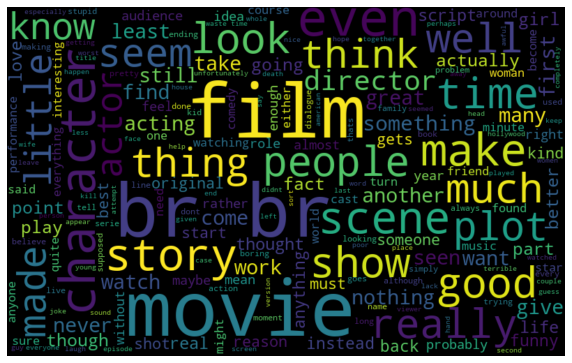

In [33]:
normal_words =' '.join([text for text in train_data['final_review'][train_data['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Words in Positive sentiment review i.eSemtiment_Label=1

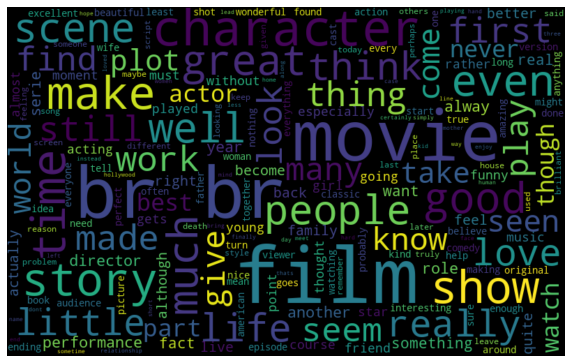

In [34]:
normal_words =' '.join([text for text in train_data['final_review'][train_data['sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Visulization of most common words in test data


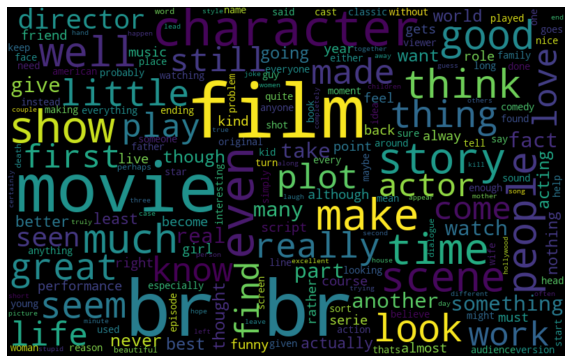

In [35]:
all_words = ' '.join([text for text in test_data['final_review_test']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Time to train the model using RNN( Recurrent Neural Network)

To train the model on the given reviews i am gonna use a advanced version of RNN called LSTM.

##  LSTM RNN Networks
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They work tremendously well on a large variety of problems, and are now widely used.

## Library under use

To train this RNN Network, I am gonna use **Keras Library** , which  is an open-source neural-network library written in Python

In [36]:
# Importing Rnn dependencies
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers


In [37]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_data['final_review'])
list_tokenized_train = tokenizer.texts_to_sequences(train_data['final_review'])

maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = train_data['sentiment']

In [38]:
X_t.shape

(25000, 130)

In [39]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_t,y,shuffle=True,test_size=0.2)

In [40]:
X_train.shape

(20000, 130)

### Building the RNN model

In [41]:
embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

- Here i use only 3 epochs because previously when i trained it for 10 epoch the outcome was like
  - Accuracy is increasing after 3 one but
  - Validation accuracy is decreasing , Which signifies that model start overfitting after 3rd epoch

In [42]:
batch_size = 100
epochs = 3
model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/3
160/160 [==============================] - 24s 137ms/step - loss: 0.4640 - accuracy: 0.7846 - val_loss: 0.3201 - val_accuracy: 0.8637
Epoch 2/3
160/160 [==============================] - 22s 138ms/step - loss: 0.2385 - accuracy: 0.9097 - val_loss: 0.3100 - val_accuracy: 0.8652
Epoch 3/3
160/160 [==============================] - 22s 135ms/step - loss: 0.1724 - accuracy: 0.9389 - val_loss: 0.3463 - val_accuracy: 0.8670


## Model Testing

In [43]:
prediction = model.predict(X_test)

In [44]:
y_pred = (prediction > 0.5)

In [45]:
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score

print('F1-score: {0}'.format(f1_score(y_pred, y_test)))

F1-score: 0.8648431214802896


In [46]:
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

Confusion matrix:


array([[2178,  291],
       [ 381, 2150]], dtype=int64)

In [47]:
print('accuracy_score:')
accuracy_score(y_pred, y_test)

accuracy_score:


0.8656

**Recall comes out to be 0.85 and precision comes out to be 11.92**